<a href="https://colab.research.google.com/github/yoshimoto-s/TensorflowObjectAPI_Colab/blob/master/ObjectDetectionTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tensorflow Object Detection APIのトレーニングをするためのColabファイルです**

---



### Step 1. 環境の準備

In [0]:
#@title Check Environment {display-mode: "form"}

#GPU環境の確認
import platform
print("python version: "+platform.python_version())

!pip install tensorflow  1>/dev/null
#現在のObjectDetectionの対応Tensorflowは1.8らしいんだけど、1.8じゃうまく動かない...
import tensorflow as tf;
print("tensorflow version: "+tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU not found')
print('GPU OK')



python version: 3.6.6
tensorflow version: 1.12.0
GPU OK


In [0]:
#@title ObjectDetectionAPI Installation {display-mode: "form"}

#install  env
print("Dependency env installing...")
!apt-get install protobuf-compiler python-pil python-lxml python-tk 1>/dev/null
!pip install Cython contextlib2 jupyter pillow lxml matplotlib 1>/dev/null
!pip install prompt_toolkit==1.0.15 1>/dev/null

%cd /content/
#特定のコミットを使用する必要があるかもしれない(要検討)
print("models cloning...")
!git clone https://github.com/tensorflow/models.git &> /dev/null

#Cocoapi
print("coco installing...")
!git clone https://github.com/cocodataset/cocoapi.git &> /dev/null
%cd cocoapi/PythonAPI
!make &>/dev/null
!cp -r pycocotools /content/models/research/

#compile protos
print("proto compiling...")
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

print("Set environ variables")
import os
os.environ['PYTHONPATH'] += ":"+os.getcwd()
os.environ['PYTHONPATH'] += ":"+os.getcwd()+"/slim"

print("Check environment")
!python object_detection/builders/model_builder_test.py


### Other treatment
!sed -i -e 's/category_index.values()/list(category_index.values())/' /content/models/research/object_detection/model_lib.py

### Other requirment
!pip install beautifulsoup4 requests 1>/dev/null
!pip install qrcode 1>/dev/null

Dependency env installing...
ipython 5.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.4, but you'll have prompt-toolkit 2.0.7 which is incompatible.
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.15 which is incompatible.
/content
models cloning...
coco installing...
/content/cocoapi/PythonAPI
proto compiling...
/content/models/research
Set environ variables
Check environment
......................
----------------------------------------------------------------------
Ran 22 tests in 0.132s

OK


### Step 2. データを準備する

Google Driveをマウントする

In [0]:
#@title Mout Google Drive {display-mode: "form"}

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


データを格納しているディレクトリを設定する

In [0]:
#@title Set Dataset Dir {display-mode:"form"}

dataset_dir = 'drive/My Drive/\u5DE8\u5927\u7A4D\u307F\u6728/\u304A\u53F0\u5834\u5B66\u7FD2\u30C6\u3099\u30FC\u30BF/2018-05-23' #@param {type: "string"}
dataset_path = "/content/"+dataset_dir

import os
print("copying files...")
os.environ['TF_DATASET_PATH'] = dataset_path
!rsync -azP --info=progress2 "$TF_DATASET_PATH" /content/dataset
!echo "copy files done!"

copying files...
     59,539,796 100%   43.23kB/s    0:22:24 (xfr#4595, to-chk=0/4638)
copy files done!


ユーティリティを定義する

In [0]:
#@title Utility Config {display-mode: "form"}

import glob
import os
from xml.etree.ElementTree import *
import time

class Util:
    @staticmethod
    def GetAvailablePreTrains(path):
        graphInfoList = []
        for root, dirs, files in os.walk(path):
            for f in files:
                if f == 'pipeline.config':
                    graphInfo = {}
                    graphInfo['pipeline_path'] = os.path.join(root, f)
                    ckpt_list = glob.glob(os.path.join(root, 'model.ckpt*.index'))
                    if len(ckpt_list) > 0:
                        ckpt_list.sort(key=lambda x: os.path.getmtime(x))
                        ckpt_prefix = ckpt_list[-1][:-6]
                        graphInfo['checkpoint_path'] = os.path.abspath(ckpt_prefix)
                    else:
                        ckpt_list = glob.glob(os.path.join(root, '*/model.ckpt*.index'))
                        if len(ckpt_list) > 0:
                            ckpt_list.sort(key=lambda x: os.path.getmtime(x))
                            ckpt_prefix = ckpt_list[-1][:-6]
                            graphInfo['checkpoint_path'] = os.path.abspath(ckpt_prefix)

                    if('pipeline_path' in graphInfo and 'checkpoint_path' in graphInfo):
                        graphInfoList.append(graphInfo)
                        #print("==============")
                        #print("%d\tpipeline_path:  \t%s" % (len(graphInfoList) - 1, graphInfo['pipeline_path']))
                        #print("  \tcheckpoint_path:\t%s" % (graphInfo['checkpoint_path']))
        return graphInfoList

    @staticmethod
    def GetGraphList(path):
        graphInfoList = []
        for root, dirs, files in os.walk(path):
            for f in files:
                if f == 'frozen_inference_graph.pb':
                    graphInfo = {}
                    graphInfo['graph_path'] = os.path.join(root, f)
                    graphInfo['label_path'] = os.path.relpath(os.path.join(root, '../labelmap.pbtxt'))
                    graphInfoList.append(graphInfo)
                    print("==============")
                    print("%d\tgraph_path:\t%s" % (len(graphInfoList) - 1, graphInfo['graph_path']))
                    print("  \tlabel_path:\t%s" % (graphInfo['label_path']))
        return graphInfoList

    @staticmethod
    def GetLabels(path):
        labels = []
        xml_files = Util.GetXmlFiles(path)
        for i,f in enumerate(xml_files):
            if i % 10 == 9 or (i + 1 == len(xml_files)):
                print("\r>> Analizing...%d/%d" % (i + 1, len(xml_files)), end='', flush=True)
            tree = parse(f) 
            elem = tree.getroot()
            for n in elem.findall(".//name"):
                if n.text not in labels:
                    labels.append(n.text)
        print("")
        return labels

    @staticmethod
    def GetXmlFiles(path):
        xml_files = []
        for root, dirs, files in os.walk(path):
            for f in files:
                if f.lower().endswith('.xml'):
                    xml_files.append(os.path.relpath(os.path.join(root,f)))
        return xml_files

    @staticmethod
    def GetJPEGFiles(path):
        jpg_files = []
        for root, dirs, files in os.walk(path):
            for f in files:
                if f.lower().endswith('.jpg'):
                    jpg_files.append(os.path.relpath(os.path.join(root,f)))
        return jpg_files
    
print("Util Define Done")

Util Define Done


ラベル情報を取得する

In [0]:
start = time.time()
labels = Util.GetLabels("/content/dataset")

print("elapsed_time:%.3f[sec]" % (time.time() - start))
print(labels)

>> Analizing...2254/2254
elapsed_time:0.835[sec]
['river', 'person', 'cloud', 'train', 'house', 'heliport']


In [0]:
#ラベリングのミスとかあったら、下記コマンドで一括修正する
#!find /content/dataset  -type f -name "*.xml" | xargs sed -i -e 's/before/after/g'

データを学習用とテスト用に分ける

In [0]:
#@title TFRecord Util {display-mode: "form"}

from object_detection.utils import dataset_util
from PIL import Image
from xml.etree.ElementTree import *
import time
from object_detection.protos import string_int_label_map_pb2
#import contextlib2
#from google3.third_party.tensorflow_models.object_detection.dataset_tools import tf_record_creation_util

def create_tf_record(xml_list, class_list, output_path):
    start = time.time()
    writer = tf.python_io.TFRecordWriter(output_path)
    class_num_list = {}
    for cn in class_list:
        class_num_list[cn] = 0
    ignoreCount = 0;
    for i,f in enumerate(xml_list):
        if i % 10 == 9 or (i + 1 == len(xml_list)):
            print("\r>> Converting...%d/%d" % (i + 1, len(xml_list)), end='', flush=True)
            
        tf_example = create_tf_example(f, class_list, class_num_list)
        if(tf_example != None):
            writer.write(tf_example.SerializeToString())
        else:
            ignoreCount += 1
    writer.close()
    print("TFRecord convert done...%d" % len(xml_list)) 
    if ignoreCount > 0:
        print("%d files ignored" % ignoreCount)
    print("-----Label counts-----")
    for k,v in class_num_list.items():
        print(k + ": " + str(v))
    elapsed_time = time.time() - start
    print("elapsed_time:%.3f[sec]" % elapsed_time)
    
    #ここより先は気が向いたら実装する
    #num_shards=10
    #output_filebase='/path/to/train_dataset.record'

    #with contextlib2.ExitStack() as tf_record_close_stack:
        #output_tfrecords = tf_record_creation_util.open_sharded_output_tfrecords(
        #tf_record_close_stack, output_filebase, num_shards)
        #for index, example in examples:
            #tf_example = create_tf_example(example)
            #output_shard_index = index % num_shards
            #output_tfrecords[output_shard_index].write(tf_example.SerializeToString())
    

def create_tf_example(xml_path, class_list, class_num_list):
    img_path = os.path.abspath(os.path.dirname(xml_path) + "/../JPEGImages") + "/" + os.path.basename(xml_path).replace('.xml','.jpg')
    if(not os.path.exists(img_path)):
        return None
    
    img = Image.open(img_path)
    height = img.size[1] # Image height
    width = img.size[0] # Image width
    #filename = img_path # Filename of the image. Empty if image is not from file
    filename = b'' # Filename of the image. Empty if image is not from file
    encoded_image_data = None # Encoded image bytes
    image_format = b'jpeg' # b'jpeg' or b'png'
    
    with tf.gfile.GFile(img_path,'rb') as fid:
        encoded_image_data = fid.read()
    

    xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
    xmaxs = [] # List of normalized right x coordinates in bounding box  (1 per box)
    ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
    ymaxs = [] # List of normalized bottom y coordinates in bounding box (1 per box)
    classes_text = [] # List of string class name of bounding box (1 per box)
    classes = [] # List of integer class id of bounding box (1 per box)
    
    tree = parse(xml_path)
    elem = tree.getroot()

    for obj in elem.getiterator("object"):
        name = obj.find("name").text
        bndbox = obj.find("bndbox")
        xmin = bndbox.find("xmin").text
        xmax = bndbox.find("xmax").text
        ymin = bndbox.find("ymin").text
        ymax = bndbox.find("ymax").text
        classes_text.append(name.encode())
        classes.append(class_list.index(name) + 1)
        xmins.append(float(xmin) / width)
        ymins.append(float(ymin) / height)
        xmaxs.append(float(xmax) / width)
        ymaxs.append(float(ymax) / height)
        class_num_list[name] += 1

    tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_image_data),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

from google.protobuf import text_format

def create_labelmap(labels, output_path):
    label_config = string_int_label_map_pb2.StringIntLabelMap()
    for i,l in enumerate(labels):
        item = label_config.item.add()
        item.name = l
        item.id = i+1
        item.display_name = l
    
    labels_text = text_format.MessageToString(label_config)
    with tf.gfile.Open(output_path, "wb") as f:
        f.write(labels_text)

In [0]:
import random
xml_files = Util.GetXmlFiles("/content/dataset")

#全体の80%を学習用、20%を評価用に使う
train_data_rate = 0.8
random.shuffle(xml_files)
split_num = int(len(xml_files) * train_data_rate)
train_xml_files = xml_files[:split_num]
test_xml_files = xml_files[split_num:]

!mkdir -p /content/tfrecords
create_tf_record(train_xml_files, labels, "/content/tfrecords/train.record")
create_tf_record(test_xml_files, labels, "/content/tfrecords/test.record")
create_labelmap(labels, "/content/tfrecords/labelmap.pbtxt")

>> Converting...1803/1803TFRecord convert done...1803
166 files ignored
-----Label counts-----
river: 1156
person: 1137
cloud: 1063
train: 1065
house: 996
heliport: 764
elapsed_time:2.032[sec]
>> Converting...451/451TFRecord convert done...451
40 files ignored
-----Label counts-----
river: 304
person: 265
cloud: 269
train: 252
house: 279
heliport: 204
elapsed_time:0.538[sec]


### Step 3. モデルを準備する

環境の準備

In [0]:
#@title List Available Models {display-mode: "form"}

!mkdir -p /content/pretrained_model/ &> /dev/null
%cd /content/pretrained_model 

import requests
from bs4 import BeautifulSoup
import os
import shutil


#@markdown 既存のデータを使う場合は下記にGoogleDriveのパスを記入
model_dir = 'drive/My Drive/Training' #@param {type: "string"}
model_path = "/content/" + model_dir

local_model_list = {}
if os.path.exists(model_path):
    gList = Util.GetAvailablePreTrains(model_path)
    for i,g in enumerate(gList):
        mName = os.path.basename(os.path.dirname(g['pipeline_path']))
        local_model_list[mName] = os.path.dirname(g['pipeline_path'])

r = requests.get("https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md")
soup = BeautifulSoup(r.text, 'lxml')

base_model_list = {}
for i,a in enumerate(soup.select('a[href^="http://download.tensorflow.org/models/object_detection/"]')):
    base_model_list[a.get_text()] = a.get('href')


model_name = ""
model_location = ""
model_type = ""
# Display List 
import IPython
from google.colab import output

def set_model_list():
    with output.redirect_to_element("#local-items"):
        for v,k in local_model_list.items():
            li_elem = "<li><ahref=\"javascript:void(0)\" onclick=\"setModel('{0}', '{1}')\">{0}</a></li>".format(v, "local")
            display(IPython.display.HTML(li_elem))
            
    with output.redirect_to_element("#base-items"):
        for v,k in base_model_list.items():
            li_elem = "<li><ahref=\"javascript:void(0)\" onclick=\"setModel('{0}', '{1}')\">{0}</a></li>".format(v, "base")
            display(IPython.display.HTML(li_elem))
                                         
def set_model(name,mtype):
    global model_name, model_type, model_location
    model_name = name
    model_type = mtype
    if mtype == "local":
        model_location = local_model_list[name]
    else:
        model_location = base_model_list[name]
    
def get_model():
    if model_type == "local":
        shutil.copytree(model_location, "/content/pretrained_model/%s" % model_name)
    else:
        !wget $model_location &> /dev/null
        !tar xzvf *.tar.gz &> /dev/null
    print("Model preparation done.")
    
output.register_callback('notebook.ShowModelList', set_model_list)
output.register_callback('notebook.SetModel', set_model)
output.register_callback('notebook.GetModel', get_model)
display(IPython.display.HTML('''
    <h3>Local Models:</h3>
    <ol id="local-items"></ol>
    <h3>Base Models:</h3>
    <ol id="base-items"></ol>
    <div>
        Selected Model:<span id="model_name"></span>
    </div>
    <button id="get-model-button" onclick="getModel()" disabled>Get Selected Model</button>
    <style type="text/css">
    <!--
    li {color:blue; line-height:1.5;cursor : pointer;text-decoration: underline;}
    -->
    </style>
    <script>
        google.colab.kernel.invokeFunction('notebook.ShowModelList', [], {});
        
        function setModel(name,type) {
            google.colab.kernel.invokeFunction('notebook.SetModel', [name, type], {});
            document.getElementById("model_name").innerHTML = name + "("+type+")" 
            document.getElementById("get-model-button").disabled = false
        }
        function getModel() {
            google.colab.kernel.invokeFunction('notebook.GetModel', [], {});
        }
    </script>
    '''))

/content/pretrained_model


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model preparation done.


### Step 4. 学習の設定をする

In [0]:
#@title Prepare Run Config {display-mode:"form"}

!mkdir -p /content/work

from object_detection.protos import pipeline_pb2
from object_detection.utils import config_util

models = Util.GetAvailablePreTrains("/content/pretrained_model")

config_path = "/content/models/research/object_detection/samples/configs/"+model_name +".config"

if model_type == "base" and os.path.exists(config_path):
    print("use samples/configs/**")
else:
    print("use model included config")
    config_path = models[0]['pipeline_path']

config = config_util.get_configs_from_pipeline_file(config_path)

if(config['model'].HasField('ssd')):
    config['model'].ssd.num_classes = len(labels)
elif(config['model'].HasField('faster_rcnn')):
    config['model'].faster_rcnn.num_classes = len(labels)

config["train_config"].fine_tune_checkpoint = models[0]['checkpoint_path']
config["train_input_config"].label_map_path = "/content/tfrecords/labelmap.pbtxt"
config["train_input_config"].tf_record_input_reader.input_path.pop()
config["train_input_config"].tf_record_input_reader.input_path.append("/content/tfrecords/train.record")
config["eval_input_config"].label_map_path = "/content/tfrecords/labelmap.pbtxt"
config["eval_input_config"].tf_record_input_reader.input_path.pop()
config["eval_input_config"].tf_record_input_reader.input_path.append("/content/tfrecords/test.record")

pipeline = config_util.create_pipeline_proto_from_configs(config)
config_util.save_pipeline_config(pipeline, "/content/work")

#!cat /content/work/pipeline.config

use samples/configs/**
INFO:tensorflow:Writing pipeline config file to /content/work/pipeline.config


In [0]:
#もしpipeline.configを手動でいじりたかったら、左のファイルリストから/work/pipeline.configをダウンロードして、上書きしてね

### Step 5. 学習の実行

tensorboard run...
/content/ngrok
ngrok run...
Watch runing status bellow
https://cc8ccbad.ngrok.io


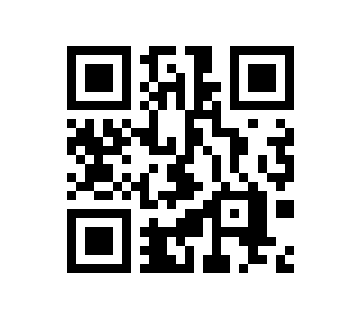

In [0]:
#@title Run Tensorboard {display-mode: "form"}
from subprocess import Popen
from time import sleep 

print("tensorboard run...")
cmd = "tensorboard --logdir /content/work/ --host 0.0.0.0 --port 6006"
proc = Popen( cmd,shell=True )
#2重起動しない仕組みいれないとなー

sleep(5)

!mkdir -p /content/ngrok
%cd /content/ngrok
!rm -rf *
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip &>/dev/null
!unzip *.zip &>/dev/null

print("ngrok run...")
cmd = "./ngrok http 6006"
proc = Popen( cmd , shell=True)
#2重起動しない仕組みいれないとなー

sleep(5)

import requests
import json
import qrcode
from PIL import Image
import matplotlib.pyplot as plt
import numpy as npj
import os.path

res = requests.get('http://localhost:4040')
import re
#print(res.text)
m = re.search(r"(https:\/\/.*?ngrok.io)", res.text)
if m:
    print("Watch runing status bellow")
    url = m.group(1)
    print(url)
    img = qrcode.make(url)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

In [0]:
#@title Log Output Dir {display-mode:"form"}

log_dir = 'drive/My Drive/Colab/TensorflowObjectDetection' #@param {type: "string"}
log_path = "/content/"+log_dir

import os
if not os.path.exists(log_path):
    print("There is not such dir: %s" % log_path)

#sync log data to google drive
from subprocess import Popen
cmd = "/bin/bash -c 'while sleep 30; do rsync -a /content/work/* \"%s\"; done'" % log_path
proc = Popen( cmd,shell=True )
print("rsync set to %s" % log_path)

rsync set to /content/drive/My Drive/Colab/TensorflowObjectDetection


学習を実行！！

In [0]:
%cd /content/models/research
!python object_detection/model_main.py  \
            --pipeline_config_path=/content/work/pipeline.config \
            --model_dir=/content/work/log \
            --num_train_steps=50000 \
            --sample_1_of_n_eval_examples=1 

/content/models/research
/content/models/research/object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "object_detection/model_main.py", line 26, in <module>
    from object_detection import model_lib
  File "/content/models/research/object_detection/model_lib.py", line 27, in <module>
    from object_detection import eval_util
  File "/content/models/research/object_detection/eval_util.py", line 27, in <module>
    from object_detection.metrics import coco_evaluation
  File "/content/models/research/object_detection/metrics/coco_evaluation.py", line 20, in <module>
    from object_detection.metrics import coco_tools
  File "/content/models/research/object_dete

In [0]:
#pipelineファイルの中身をみたければ...
#!cat /content/work/pipeline.config

### Step 6. 学習データをエクスポートする

In [0]:
import glob
import os

search_dir = "/content/work/log/"
files = filter(os.path.isfile, glob.glob("/content/work/log/model.ckpt*"))
files.sort(key=lambda x: os.path.getmtime(x))

#!python object_detection/export_inference_graph.py \
#    --input_type=image_tensor \
#    --pipeline_config_path=/content/work/pipeline.config \
#    --trained_checkpoint_prefix= \
#    --output_directory=/content/work/export

### Appendix SandBox

In [0]:
#学習プロセスが動いているか確認
!ps auxf | grep model_main | grep -v grep

In [0]:
!ps aux | grep tensorboard | grep -v grep

In [0]:
!ps aux | grep ngrok | grep -v grep

In [0]:
#学習ログを削除
!rm -rf /content/work/log

In [0]:
!ps aux | grep while

root        3818  0.0  0.0  34300  4716 ?        S    07:40   0:00 /bin/sh -c /bin/bash -c 'while sleep 30; do rsync -a /content/work/* "/content/drive/My Drive/Colab/TensorflowObjectDetection"; done'
root        3819  0.0  0.0  39192  6384 ?        S    07:40   0:00 /bin/bash -c while sleep 30; do rsync -a /content/work/* "/content/drive/My Drive/Colab/TensorflowObjectDetection"; done
root        3821  0.0  0.0  39192  6540 ?        S    07:40   0:00 /bin/bash -c ps aux | grep while
root        3823  0.0  0.0  38572  5616 ?        S    07:40   0:00 grep while


In [0]:
!kill -9 3515